<a href="https://www.kaggle.com/code/william900508/cv-final-project?scriptVersionId=214524206" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install pycocotools
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import os
from pycocotools.coco import COCO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 7.2 MB/s eta 0:00:00


In [2]:

import os
import random
from pycocotools.coco import COCO
import shutil


train_annotations_path = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/instances_train2014.json'
train_images_path = '/kaggle/input/coco-image-caption/train2014/train2014/'
test_annotations_path = '/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/instances_val2017.json'
test_images_path = '/kaggle/input/coco-image-caption/val2017/val2017/'


output_dir = '/kaggle/working/coco_human_nonhuman_dataset'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/human'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/non_human'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/human'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/non_human'), exist_ok=True)





train_coco = COCO(train_annotations_path)
test_coco = COCO(test_annotations_path)

loading annotations into memory...
Done (t=15.13s)
creating index...
index created!
loading annotations into memory...
Done (t=1.02s)
creating index...
index created!


In [3]:



def filter_images_with_annotations(coco_instance, category_id, min_area=500):
    annotations = coco_instance.loadAnns(coco_instance.getAnnIds(catIds=category_id))
    filtered_image_ids = set(
        ann['image_id']
        for ann in annotations
        if 'bbox' in ann and ann['area'] > min_area
    )
    return list(filtered_image_ids)


def filter_images_exclude_category(coco_instance, include_category_ids, exclude_category_ids, min_area=500):

    include_annotations = coco_instance.loadAnns(coco_instance.getAnnIds(catIds=include_category_ids))
    include_image_ids = set(
        ann['image_id']
        for ann in include_annotations
        if 'bbox' in ann and ann['area'] > min_area
    )
    

    exclude_annotations = coco_instance.loadAnns(coco_instance.getAnnIds(catIds=exclude_category_ids))
    exclude_image_ids = set(ann['image_id'] for ann in exclude_annotations)


    filtered_image_ids = include_image_ids - exclude_image_ids
    return list(filtered_image_ids)



# ----------------------------------


human_train_image_ids = filter_images_with_annotations(train_coco, category_id=1, min_area=500)
human_test_image_ids = filter_images_with_annotations(test_coco, category_id=1, min_area=500)


human_train_image_ids = random.sample(human_train_image_ids, min(8000, len(human_train_image_ids)))
human_test_image_ids = random.sample(human_test_image_ids, min(800, len(human_test_image_ids)))


non_human_category_ids = list(range(16, 26))
non_human_train_image_ids = []
non_human_test_image_ids = []

for category_id in non_human_category_ids:
    non_human_train_image_ids.extend(filter_images_exclude_category(
        train_coco, include_category_ids=[category_id], exclude_category_ids=[1], min_area=500
    ))
    non_human_test_image_ids.extend(filter_images_exclude_category(
        test_coco, include_category_ids=[category_id], exclude_category_ids=[1], min_area=500
    ))


non_human_train_image_ids = random.sample(list(set(non_human_train_image_ids)), min(2000, len(non_human_train_image_ids)))
non_human_test_image_ids = random.sample(list(set(non_human_test_image_ids)), min(200, len(non_human_test_image_ids)))


def copy_images(image_ids, source_dir, target_dir, coco_instance):
    for img_id in image_ids:
        img_info = coco_instance.loadImgs([img_id])[0]
        img_path = os.path.join(source_dir, img_info['file_name'])
        if os.path.exists(img_path):
            shutil.copy(img_path, target_dir)


copy_images(human_train_image_ids, train_images_path, os.path.join(output_dir, 'train/human'), train_coco)
copy_images(human_test_image_ids, test_images_path, os.path.join(output_dir, 'test/human'), test_coco)


copy_images(non_human_train_image_ids, train_images_path, os.path.join(output_dir, 'train/non_human'), train_coco)
copy_images(non_human_test_image_ids, test_images_path, os.path.join(output_dir, 'test/non_human'), test_coco)


train_human_count = len(os.listdir(os.path.join(output_dir, 'train/human')))
train_non_human_count = len(os.listdir(os.path.join(output_dir, 'train/non_human')))
test_human_count = len(os.listdir(os.path.join(output_dir, 'test/human')))
test_non_human_count = len(os.listdir(os.path.join(output_dir, 'test/non_human')))

print(f"Train Human: {train_human_count}")
print(f"Train Non-Human: {train_non_human_count}")
print(f"Test Human: {test_human_count}")
print(f"Test Non-Human: {test_non_human_count}")


Train Human: 8000
Train Non-Human: 2000
Test Human: 800
Test Non-Human: 200


# 檢查資料內容

In [4]:
# categories = train_coco.loadCats(train_coco.getCatIds())
# for cat in categories:
#     print(f"ID: {cat['id']}, Name: {cat['name']}")
# # 

In [5]:
# from pycocotools.coco import COCO
# import matplotlib.pyplot as plt
# import os
# from PIL import Image


# annotations_path = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/instances_train2014.json'
# images_path = '/kaggle/input/coco-image-caption/train2014/train2014/'


# coco = COCO(annotations_path)


# person_category_id = 1
# person_image_ids = coco.getImgIds(catIds=person_category_id)


# import random
# selected_image_ids = random.sample(person_image_ids, 5)


# def show_coco_images(image_ids, coco, images_path):
#     plt.figure(figsize=(15, 10))
#     for i, img_id in enumerate(image_ids):
#         img_info = coco.loadImgs(img_id)[0]
#         img_path = os.path.join(images_path, img_info['file_name'])
        
#        
#         image = Image.open(img_path)
        
#        
#         plt.subplot(1, len(image_ids), i + 1)
#         plt.imshow(image)
#         plt.axis('off')
#         plt.title(f"Image ID: {img_info['id']}")
#     plt.tight_layout()
#     plt.show()


# show_coco_images(selected_image_ids, coco, images_path)


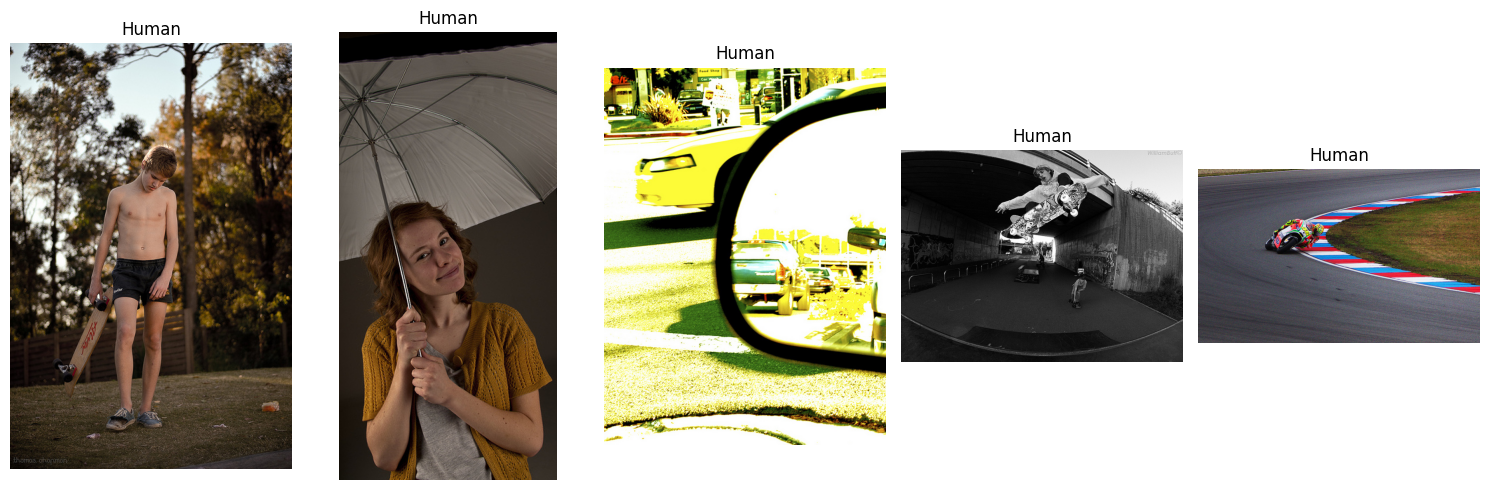

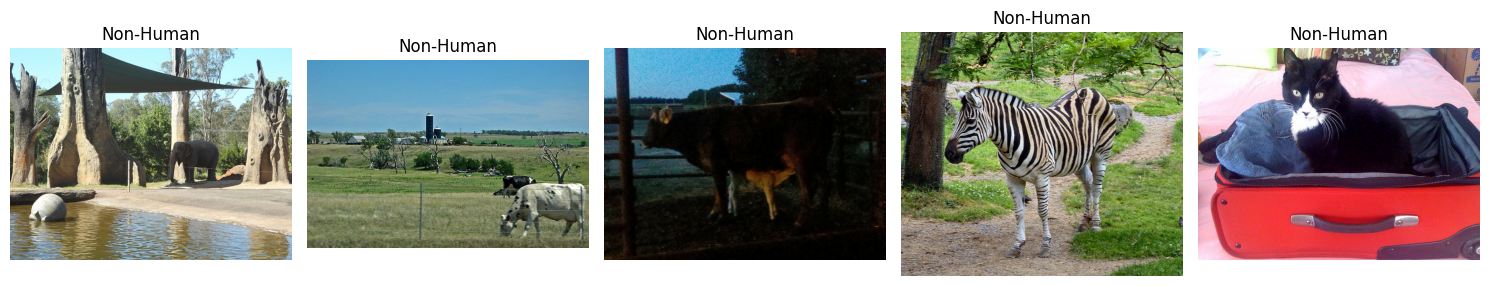

In [6]:
import matplotlib.pyplot as plt
import random
from PIL import Image


train_human_dir = os.path.join(output_dir, 'train/human')
train_non_human_dir = os.path.join(output_dir, 'train/non_human')


def get_random_images(dir_path, num_images=5):
    images = os.listdir(dir_path)
    selected_images = random.sample(images, num_images)
    return [os.path.join(dir_path, img) for img in selected_images]


human_images = get_random_images(train_human_dir, num_images=5)
non_human_images = get_random_images(train_non_human_dir, num_images=5)


def display_images_in_row(images, label):
    num_images = len(images)
    plt.figure(figsize=(15, 5))  
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)  
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
    plt.tight_layout()
    plt.show()


human_images = get_random_images(train_human_dir, num_images=5)
non_human_images = get_random_images(train_non_human_dir, num_images=5)


display_images_in_row(human_images, label="Human")

display_images_in_row(non_human_images, label="Non-Human")


In [7]:
import pandas as pd
output_dir = '/kaggle/working/coco_human_nonhuman_dataset'

train_human_dir = os.path.join(output_dir, 'train/human')
train_non_human_dir = os.path.join(output_dir, 'train/non_human')
test_human_dir = os.path.join(output_dir, 'test/human')
test_non_human_dir = os.path.join(output_dir, 'test/non_human')


def create_dataset(image_dir, label):
    image_files = os.listdir(image_dir)
    data = [{'file_path': os.path.join(image_dir, img), 'label': label} for img in image_files]
    return data


train_data = create_dataset(train_human_dir, label=1) + create_dataset(train_non_human_dir, label=0)


test_data = create_dataset(test_human_dir, label=1) + create_dataset(test_non_human_dir, label=0)


train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)


train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)


train_csv_path = os.path.join(output_dir, 'train_dataset.csv')
test_csv_path = os.path.join(output_dir, 'test_dataset.csv')
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)


print(f"訓練資料集儲存於: {train_csv_path}, 總數: {len(train_df)}")
print(f"測試資料集儲存於: {test_csv_path}, 總數: {len(test_df)}")


print("\n訓練資料集部分資料:")
print(train_df.head())

print("\n測試資料集部分資料:")
print(test_df.head())


訓練資料集儲存於: /kaggle/working/coco_human_nonhuman_dataset/train_dataset.csv, 總數: 10000
測試資料集儲存於: /kaggle/working/coco_human_nonhuman_dataset/test_dataset.csv, 總數: 1000

訓練資料集部分資料:
                                           file_path  label
0  /kaggle/working/coco_human_nonhuman_dataset/tr...      1
1  /kaggle/working/coco_human_nonhuman_dataset/tr...      0
2  /kaggle/working/coco_human_nonhuman_dataset/tr...      1
3  /kaggle/working/coco_human_nonhuman_dataset/tr...      0
4  /kaggle/working/coco_human_nonhuman_dataset/tr...      1

測試資料集部分資料:
                                           file_path  label
0  /kaggle/working/coco_human_nonhuman_dataset/te...      0
1  /kaggle/working/coco_human_nonhuman_dataset/te...      1
2  /kaggle/working/coco_human_nonhuman_dataset/te...      0
3  /kaggle/working/coco_human_nonhuman_dataset/te...      1
4  /kaggle/working/coco_human_nonhuman_dataset/te...      0


In [8]:
(train_df.label ==0 ).sum()

2000

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os


output_dir = '/kaggle/working/coco_human_nonhuman_dataset'

batch_size = 32
num_epochs = 40
learning_rate = 0.001


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)


train_csv = os.path.join(output_dir, 'train_dataset.csv')
test_csv = os.path.join(output_dir, 'test_dataset.csv')

train_dataset = CustomDataset(train_csv, transform=transform)
test_dataset = CustomDataset(test_csv, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
# model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 類別輸出
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
          
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")
    print("訓練完成！")


def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_loss_history = []
    train_acc_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
   
            outputs = model(images)
            loss = criterion(outputs, labels)
            
     
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    return train_loss_history, train_acc_history


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    print(f"測試準確率: {accuracy:.2f}%")
    return accuracy



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


In [10]:

train_loss_history, train_acc_history = train_model(model, train_loader, criterion, optimizer, num_epochs)


test_accuracy = evaluate_model(model, test_loader)


model_save_path = os.path.join(output_dir, 'resnet50_human_classifier.pth')
torch.save(model.state_dict(), model_save_path)
print(f"模型已儲存至: {model_save_path}")



Epoch [1/40], Loss: 0.3880, Accuracy: 84.59%
Epoch [2/40], Loss: 0.3274, Accuracy: 86.77%
Epoch [3/40], Loss: 0.3007, Accuracy: 87.52%
Epoch [4/40], Loss: 0.2916, Accuracy: 87.82%
Epoch [5/40], Loss: 0.2625, Accuracy: 88.86%
Epoch [6/40], Loss: 0.2513, Accuracy: 89.67%
Epoch [7/40], Loss: 0.2305, Accuracy: 90.53%
Epoch [8/40], Loss: 0.2232, Accuracy: 91.25%
Epoch [9/40], Loss: 0.2142, Accuracy: 91.14%
Epoch [10/40], Loss: 0.1907, Accuracy: 92.40%
Epoch [11/40], Loss: 0.1749, Accuracy: 92.97%
Epoch [12/40], Loss: 0.1588, Accuracy: 93.79%
Epoch [13/40], Loss: 0.1453, Accuracy: 94.16%
Epoch [14/40], Loss: 0.1247, Accuracy: 95.00%
Epoch [15/40], Loss: 0.1191, Accuracy: 95.27%
Epoch [16/40], Loss: 0.0896, Accuracy: 96.62%
Epoch [17/40], Loss: 0.0929, Accuracy: 96.38%
Epoch [18/40], Loss: 0.0756, Accuracy: 97.14%
Epoch [19/40], Loss: 0.0762, Accuracy: 97.08%
Epoch [20/40], Loss: 0.0637, Accuracy: 97.64%
Epoch [21/40], Loss: 0.0648, Accuracy: 97.62%
Epoch [22/40], Loss: 0.0525, Accuracy: 98.1

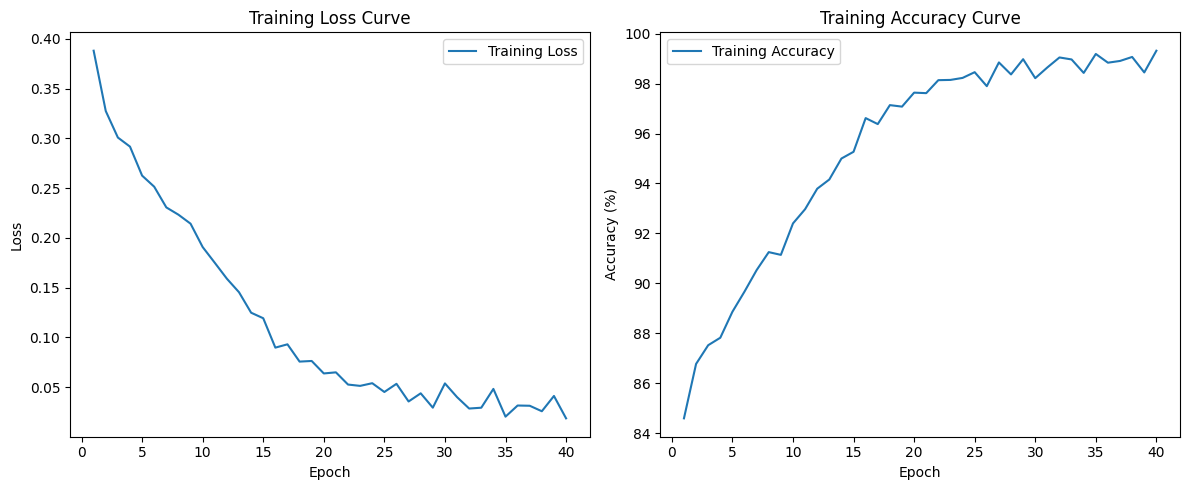

In [11]:

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_23/3130063598.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

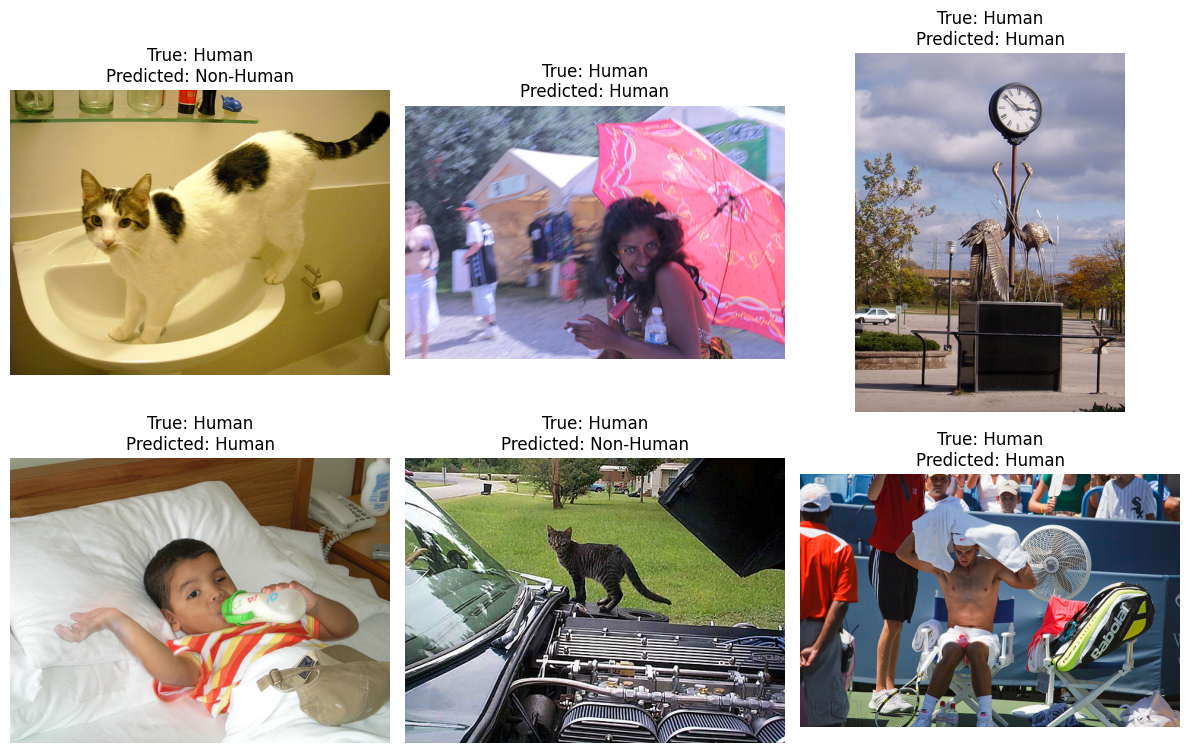

In [12]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)  # 不需要預訓練權重，因為我們要載入自己的權重
model.fc = nn.Linear(model.fc.in_features, 2)  # 2類輸出
model = model.to(device)


model_save_path = os.path.join(output_dir, 'resnet50_human_classifier.pth')
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_images_dir = os.path.join(output_dir, 'test')
human_dir = os.path.join(test_images_dir, 'human')
non_human_dir = os.path.join(test_images_dir, 'non_human')


def get_random_test_images(num_images=5):
    human = [os.path.join(human_dir, f) for f in os.listdir(human_dir)]
    non_human = [os.path.join(non_human_dir, f) for f in os.listdir(non_human_dir)]
    selected_images = random.sample(human, num_images // 2) + random.sample(non_human, num_images // 2)
    random.shuffle(selected_images)  
    return selected_images


def predict_image(model, image_path, transform):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # 加入 batch 維度
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    label = predicted.item()
    return label


def display_predictions(model, image_paths, transform):
    plt.figure(figsize=(12, 8))
    for i, image_path in enumerate(image_paths):
        label = predict_image(model, image_path, transform)
        true_label = "Human" if "human" in image_path else "Non-Human"
        predicted_label = "Human" if label == 1 else "Non-Human"


        image = Image.open(image_path)
        plt.subplot(2, len(image_paths) // 2, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.tight_layout()
    plt.show()


test_images = get_random_test_images(num_images=6) 
display_predictions(model, test_images, transform)
